#### Attention: 
Ce notebook a été développé par des étudiants universitaires de PolyFinances et n'émane pas des conférenciers de la CDPQ. Nous ne pouvons garantir son absence totale d'erreurs. Il est mis à votre disposition comme un outil pour vous aider dans l'élaboration de vos solutions et pour vous montrer les notions théoriques issues du domaine de la finance pouvant être utilisées

*Auteur: Jérémy Langevin*

# Atelier 1 - Prédiction avec du Machine Learning

L'atelier suivant propose une courte introduction aux différents modèles prédictifs. Nous allons survoler les éléments suivants:
- Séries temporelles et indicateurs
- Régressions simples (linéaires, quadratiques)
- Modèles à mémoire


In [67]:
#%%capture pip install numpy pandas matplotlib scikit-learn

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Séries temporelles

Tout d'abord, qu'est-ce qu'une série temporelle? Il s'agit d'un emsemble d'observations qui se déroulent sur une période donnée. Lorsqu'appliquée en prédiction, on ajuste ces observations selon un fréquence régulière, telle que journalière, hebdomadaire ou mensuelle.



In [69]:
def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

In [70]:
df = pd.read_csv(
    "../kaggle/input/dt23-test/series/adjusted_close.csv",
    index_col='timestamp',
    parse_dates=['timestamp'],
)

df.fillna(-1)
df = df.drop(df[df['adjusted_close_CSCO'] == -1].index)
df = df.sort_index(ascending=False)
df = df.iloc[0:(365*5)]
#df = df.dropna(axis=0, subset=['adjusted_close_CSCO'])
df = df.iloc[::-1]
df

,adjusted_close_CSCO,adjusted_close_ISRG,adjusted_close_TPR,adjusted_close_DVN,adjusted_close_MRO,adjusted_close_BA,adjusted_close_GILD,adjusted_close_MDT,adjusted_close_V,adjusted_close_A,...,adjusted_close_CI,adjusted_close_BALL,adjusted_close_JNJ,adjusted_close_DOV,adjusted_close_CRM,adjusted_close_PGR,adjusted_close_WAT,adjusted_close_BWA,adjusted_close_BLK,adjusted_close_PPL
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-07-08,23.373799,75.426591,33.953317,28.631794,13.559587,118.659113,66.358195,74.123287,72.731759,42.944114,...,123.459279,33.410827,101.276884,49.812896,80.89,27.930340,146.53,23.991889,286.849375,26.440916
2016-07-11,23.509601,74.855481,34.296445,28.700364,13.350559,120.437768,66.128184,74.249119,72.826933,42.868575,...,122.287559,33.448147,101.342836,50.329863,81.66,27.781113,145.78,24.337209,288.760596,26.567968
2016-07-12,23.653390,75.034369,34.794797,30.483185,14.177585,119.315847,66.419531,74.593059,73.740601,43.935568,...,122.887709,33.252216,101.334592,51.009709,81.93,27.573854,147.61,24.596199,296.962228,26.327981
2016-07-13,23.765226,74.759925,34.320954,29.713677,13.895850,118.677356,65.744832,74.450450,73.721566,43.822259,...,124.021324,33.275541,101.400543,51.215079,81.33,27.582144,147.92,24.462779,297.070254,26.483267
2016-07-14,23.773215,75.066592,34.459839,29.248924,13.877674,119.990824,65.583824,74.517560,74.368747,44.190513,...,123.849853,33.261546,101.548934,51.392122,81.56,27.739661,149.27,24.753162,295.150723,26.179754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,53.997474,294.980000,28.580000,45.650000,25.590000,187.830000,74.100000,77.770000,231.270000,110.900000,...,287.540000,49.260000,155.150000,137.680000,203.71,138.872313,270.52,39.860000,643.040000,22.550000
2023-10-03,53.650000,288.040000,27.950000,45.750000,25.680000,188.920000,73.270000,76.540000,228.810000,110.260000,...,284.410000,48.730000,155.340000,137.780000,199.83,139.302010,265.01,38.870000,625.470000,22.980000
2023-10-04,53.450000,290.280000,27.840000,43.350000,24.400000,186.730000,74.740000,76.270000,231.220000,111.670000,...,285.080000,49.270000,155.520000,137.920000,201.87,142.160000,267.76,39.220000,636.530000,22.910000


On observe que chaque série de données est associé à une date en particulier. C'est ce qui va nous permettre de créer, par la suite, notre modèle prédictif. Le modèle majoritairement utilisé au niveau de prédiction de portefeuille (comme dans la compétition!) est un mod

## Indicateurs
On retrouve 3 indicateurs applicable à nos séries temporelles, soit:
- Le Alpha
- Le Beta
- Le ratio de Sharpe


1. Le Alpha représente un coefficient utilisé lors de l'assouplissement exponentiel simple d'une série temporelle sans tendance ou saisonnalité. La valeur du Alpha se situe toujours entre 0 et 1.

2. Le Beta est un facteur appliqué lors d'un assouplissement exponentiel double d'une série temporelle. On cherche à utiliser l'assouplissement exponentiel double lorsqu'on retrouve une tendance linéaire, mais sans saisonnalité. Il s'agit d'introduire un term qui nous permet de considérer la possibilié que notre série présente une forme de tendance.

3. Alors que le Alpha et le Beta sont plus des indicateurs appliqués aux séries temporelles prédictives, le ratio de Sharpe est un ratio financier qui nous permet de comparer le retour sur investissement d'un indice par rapport à son risque. Le ratio nous indique en retour la volatilité et le risque de l'indice, afin de vérifier le risque ajusté d'un titre. 

## Régressions linéaires

Les régressions linéaires sont des façon simples de représenter une tendance dans une série temporelle. L'algorithme apprend comment faire une somme pesée à partir de ses intrants.

`target = weight_1 * feature_1 + weight_2 * feature_2 + bias`



In [71]:
df['Time'] = np.arange(len(df.index))

plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [72]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'adjusted_close_CSCO']  # target

model = LinearRegression(fit_intercept=True)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

Text(0.5, 1.0, 'Time Plot of Adjusted Close')

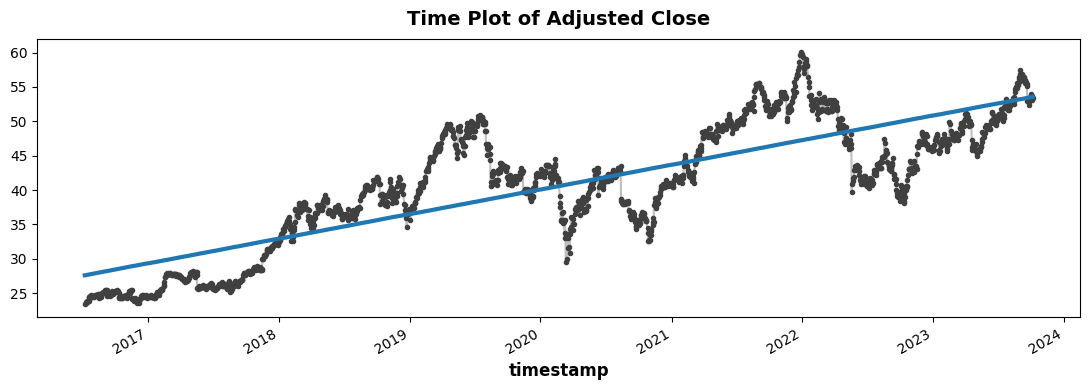

In [73]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Adjusted Close')

### Séries décalées


In [74]:
df['Lag_1'] = df['adjusted_close_CSCO'].shift(1)
df.head()

from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True) 
y = df.loc[:, 'adjusted_close_CSCO']
y, X = y.align(X, join='inner')  

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

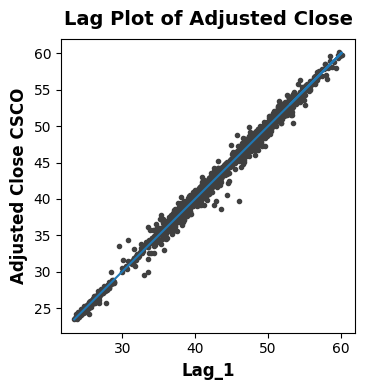

In [75]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Adjusted Close CSCO')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Adjusted Close');

## Régressions quadratiques (Moving Average)


<Axes: title={'center': 'Adjusted Close, weekly average'}, xlabel='timestamp'>

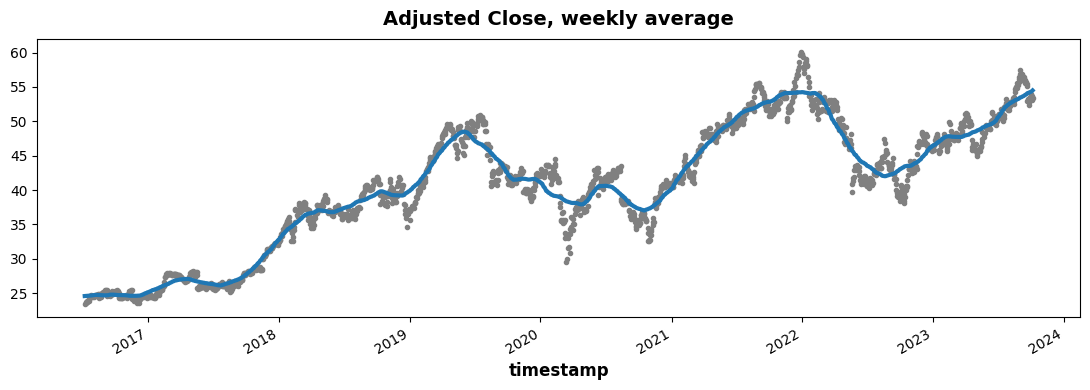

In [76]:
moving_average = df['adjusted_close_CSCO'].rolling(
    window=90,       
    center=True,       
    min_periods=45,   
).mean()              

ax = df['adjusted_close_CSCO'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Adjusted Close, weekly average", legend=False,
)

In [77]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df.index,      
    constant=True,     
    order=3,             
    drop=True,           
)

X = dp.in_sample()

In [78]:
from sklearn.linear_model import LinearRegression

y = df["adjusted_close_CSCO"]  # the target

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
X

,const,trend,trend_squared,trend_cubed
timestamp,,,,
2016-07-08,1.0,1.0,1.0,1.000000e+00
2016-07-11,1.0,2.0,4.0,8.000000e+00
2016-07-12,1.0,3.0,9.0,2.700000e+01
2016-07-13,1.0,4.0,16.0,6.400000e+01
2016-07-14,1.0,5.0,25.0,1.250000e+02
...,...,...,...,...
2023-10-02,1.0,1821.0,3316041.0,6.038511e+09
2023-10-03,1.0,1822.0,3319684.0,6.048464e+09
2023-10-04,1.0,1823.0,3323329.0,6.058429e+09


<Axes: title={'center': 'Adjusted Close'}, xlabel='timestamp'>

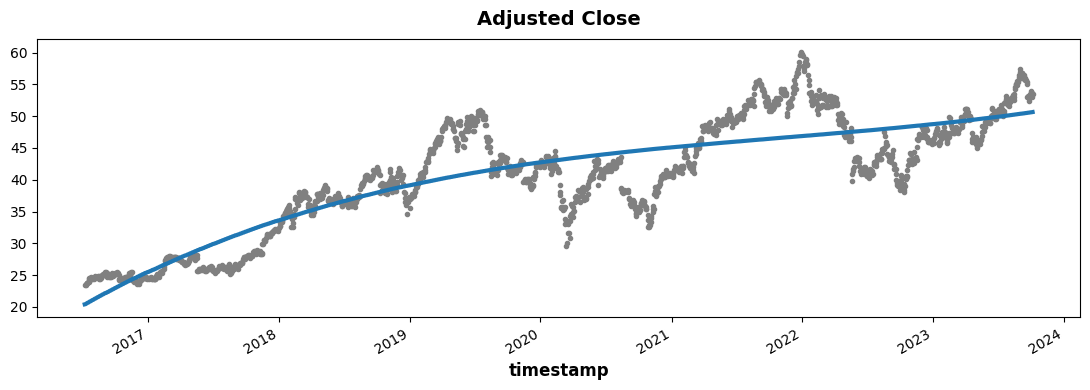

In [79]:
ax = df['adjusted_close_CSCO'].plot(style=".", color="0.5", title="Adjusted Close")
y_pred.plot(ax=ax, linewidth=3, label="Trend")

/Users/fedwi/Documents/2023 Log session 7/Datathon PF 2023/datathon-23 light version/.venv/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


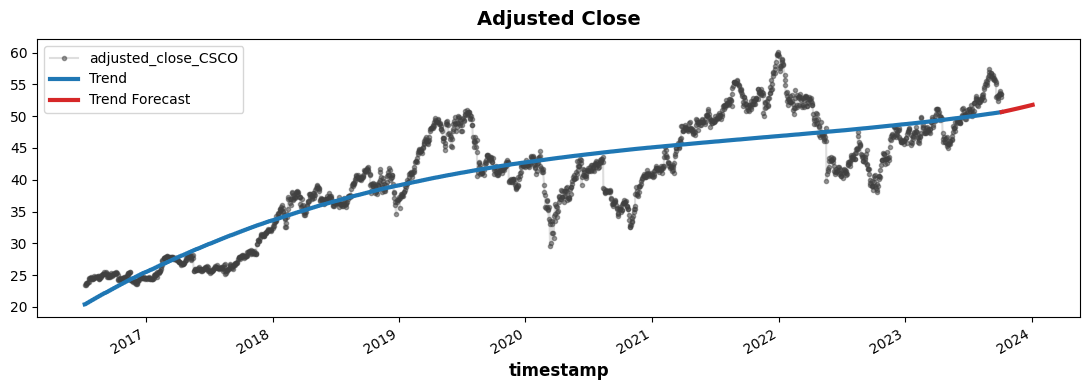

In [80]:
X_fore = dp.out_of_sample(steps=90)

start_date = df.index[-1] + pd.Timedelta(days=1) 
forecast_steps = len(X_fore)
step_size = pd.Timedelta(days=1)  

date_time_index = pd.date_range(start=start_date, periods=forecast_steps, freq=step_size)

X_fore.index = date_time_index

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)



ax = y.plot(**plot_params, alpha=0.5, title="Adjusted Close")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()

## Modèles à Mémoire

1. RNN
2. LSTM
3. GRU

https://www.kaggle.com/code/ryanholbrook/forecasting-with-machine-learning